In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from scipy import stats
from skimage import filters
from tqdm.notebook import tqdm
from pyimzml.ImzMLParser import ImzMLParser, getionimage
from typing import List, Tuple, Dict

In [2]:
# Define folder that contains the dhg dataset
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the preprocessed dhg images
DHG_IN_PATH = f"{DHG_PATH}/preprocessed"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define the type of wanted correlation
CORR_TYPE = "spearman"

In [3]:
# read metadata csv
metadata_df = pd.read_csv(METADATA_PATH)

In [4]:
def corr(i_keys: List[str],
         j_keys: List[str],
         i_vals: Dict[str, np.ndarray],
         j_vals: Dict[str, np.ndarray],
         corr_type: str = "pearson") -> pd.DataFrame:
  """Function to calculate correlation matrix

  Args:
      i_keys (List[str]):  Matrix i (rows) keys.
      j_keys (List[str]): Matrix i (columns) keys.
      i_vals (Dict[str, np.ndarray]): Dict with keys corresponding to i_keys
        and values of the keys.
      j_vals (Dict[str, np.ndarray]): Dict with keys corresponding to j_keys
        and values of the keys.
      corr_type (str, optional): Correlation type . Defaults to "pearson".
      

  Returns:
      pd.DataFrame: Correlation matrix where index is i_keys and columns are
        j_keys and each cell [i_key, j_key] is the correlation between i_val
        and j_val.

  """
  # Create empty correlation matrix
  corr_m = np.zeros((len(i_keys), len(j_keys)))
  # Loop over i keys
  for idx_i, key_i in enumerate(i_keys):
    # Loop over j keys
    for idx_j, key_j in enumerate(j_keys):
      # Calculate corelation between i_val and j_val
      if corr_type == "kendall":
        corr_m[idx_i, idx_j] = stats.kendalltau(i_vals[key_i], j_vals[key_j])[0]
      elif corr_type == "spearman":
        corr_m[idx_i, idx_j] = stats.spearmanr(i_vals[key_i], j_vals[key_j])[0]
      else:
        corr_m[idx_i, idx_j] = stats.pearsonr(i_vals[key_i], j_vals[key_j])[0]
  # return correlation data frame
  return pd.DataFrame(corr_m, index=i_keys, columns=j_keys)

In [5]:
def read_msi(p: ImzMLParser) -> Tuple[np.ndarray, np.ndarray]:
  """
    Function to read a continuos imzML parser object into a numpy array.

    Args:
        p (ImzMLParser): The imzML parser.
    Returns:
        Tuple[np.ndarray, np.ndarray]: Numpy 3D matrix where y coordinate
            (axis=0), x coordinate (axis=1), intensities values (axis=2)
            and continuos mzs values.

    """
  # Get shape of mzs values
  max_z = p.mzLengths[0]
  # Get shape of y axis
  max_y = p.imzmldict["max count of pixels y"]
  # Get shape of x axis
  max_x = p.imzmldict["max count of pixels x"]
  # Create empty numpy 3D matrix
  msi = np.zeros((max_y, max_x, max_z))
  # Loop over each coordinate and add to 3D matrix
  for i, (x, y, _) in tqdm(enumerate(p.coordinates),
                           total=len(p.coordinates),
                           desc="Spectra Loop"):
    # Get mzs and intenisties
    mzs, ints = p.getspectrum(i)
    # Add intenisties to x,y coordinate
    msi[y - 1, x - 1, :] = ints
  return mzs, msi

In [6]:
# Create dict's to store each sample spectra's sum and count
# for tissue and non tissue spectra's
tissue_spectras_mean = {}
non_tissue_spectras_mean = {}

# Define object to store common mz values
mzs = None

# Loop over each sample
for _, row in tqdm(metadata_df.iterrows(),
                   total=metadata_df.shape[0],
                   desc="MSI Loop"):
  #
  with ImzMLParser(os.path.join(DHG_IN_PATH,
                                f"{row.sample_file_name}.imzML")) as reader:
    #
    mzs, data = read_msi(reader)
    #
    local_tic_img = data[:, :, ((mzs > 600) & (mzs < 900))].sum(axis=-1)
    # Threshold image to separate tissue spectra from background
    thresh_img = local_tic_img > filters.threshold_mean(local_tic_img)
    #
    tissue_spectras_mean[row.sample_file_name] = data[thresh_img, :].mean(axis=0)
    #
    non_tissue_spectras_mean[row.sample_file_name] = data[~thresh_img, :].mean(axis=0)

MSI Loop:   0%|          | 0/48 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2254 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2596 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2772 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2412 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1856 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4368 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4875 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3871 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2508 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3465 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3074 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2928 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3604 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4422 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3111 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4488 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1620 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1584 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3477 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4256 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3835 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4500 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3658 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4400 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2583 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2852 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2916 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3484 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1496 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1452 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2184 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1395 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1470 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4896 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2898 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1710 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1850 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2184 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1377 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4420 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3111 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2562 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5135 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5934 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3192 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4026 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1886 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2304 [00:00<?, ?it/s]

# ***Without z-score normalization:***

### ***Tissue2Tissue correlation Section2Section:***

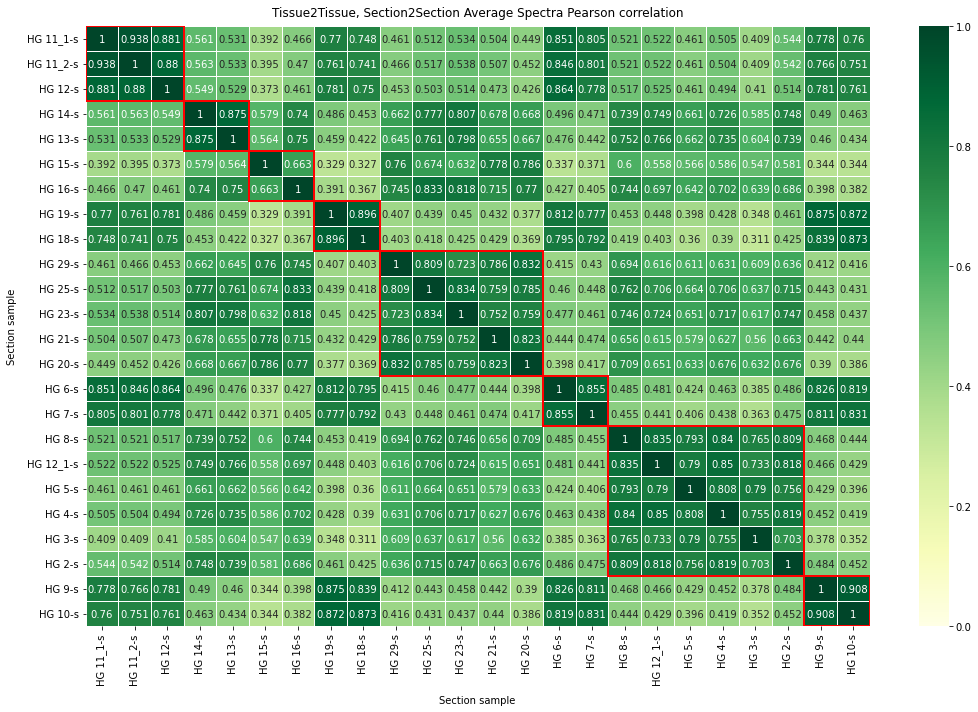

In [12]:
# Create correlation data frame
s_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "section"].sample_file_name
s_sample_file_name = s_sample_file_name.reset_index(drop=True)

corr_df = corr(s_sample_file_name, s_sample_file_name, tissue_spectras_mean,
                tissue_spectras_mean, corr_type=CORR_TYPE)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("Tissue2Tissue, Section2Section Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Section sample", labelpad=10)
ax.set_xlabel(f"Section sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "section"].groupby('file_name'):
  start_i = s_sample_file_name[s_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = s_sample_file_name[s_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***NonTissue2NonTissue correlation Section2Section:***

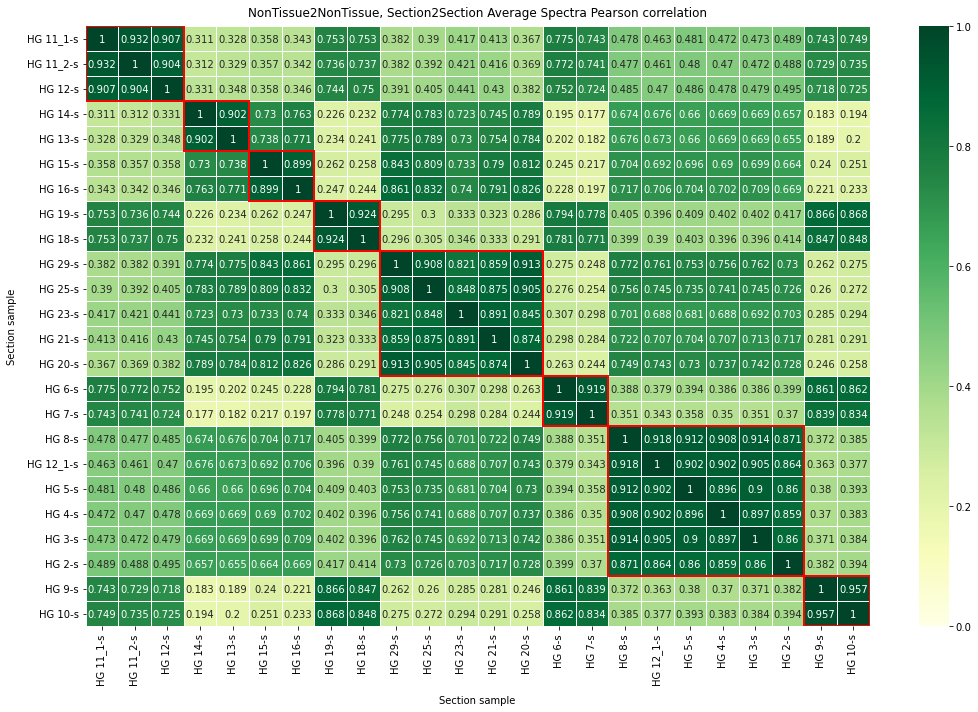

In [13]:
# Create correlation data frame
s_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "section"].sample_file_name
s_sample_file_name = s_sample_file_name.reset_index(drop=True)

corr_df = corr(s_sample_file_name, s_sample_file_name, non_tissue_spectras_mean,
                non_tissue_spectras_mean, corr_type=CORR_TYPE)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("NonTissue2NonTissue, Section2Section Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Section sample", labelpad=10)
ax.set_xlabel(f"Section sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "section"].groupby('file_name'):
  start_i = s_sample_file_name[s_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = s_sample_file_name[s_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***Tissue2NonTissue correlation Section2Section:***

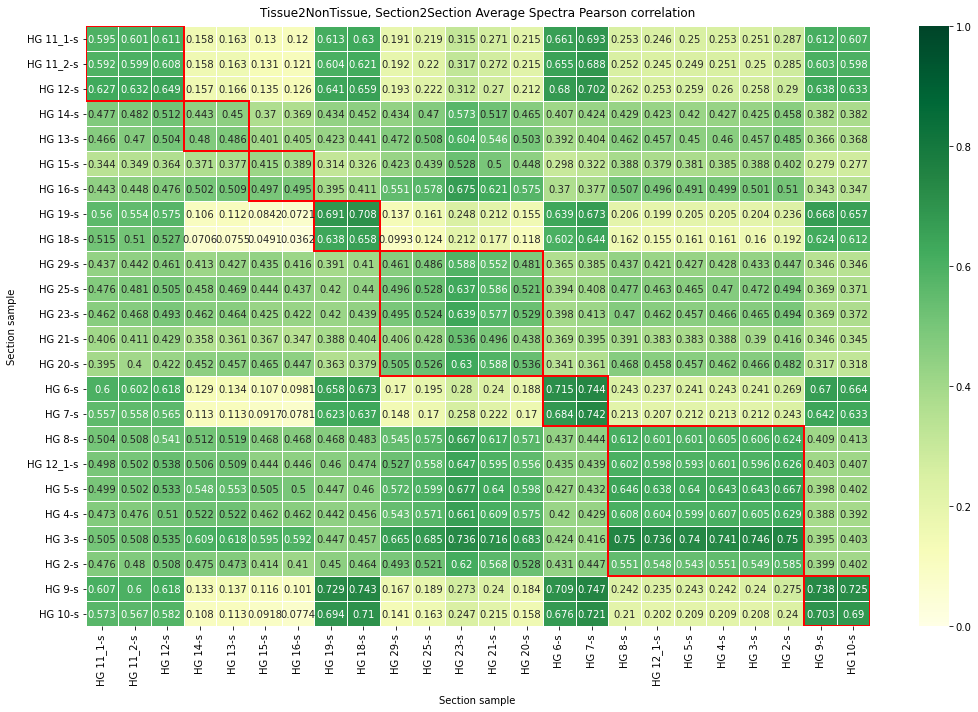

In [14]:
# Create correlation data frame
s_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "section"].sample_file_name
s_sample_file_name = s_sample_file_name.reset_index(drop=True)

corr_df = corr(s_sample_file_name, s_sample_file_name, tissue_spectras_mean,
                non_tissue_spectras_mean, corr_type=CORR_TYPE)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("Tissue2NonTissue, Section2Section Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Section sample", labelpad=10)
ax.set_xlabel(f"Section sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "section"].groupby('file_name'):
  start_i = s_sample_file_name[s_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = s_sample_file_name[s_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***Tissue2Tissue correlation Replica2Replica:***

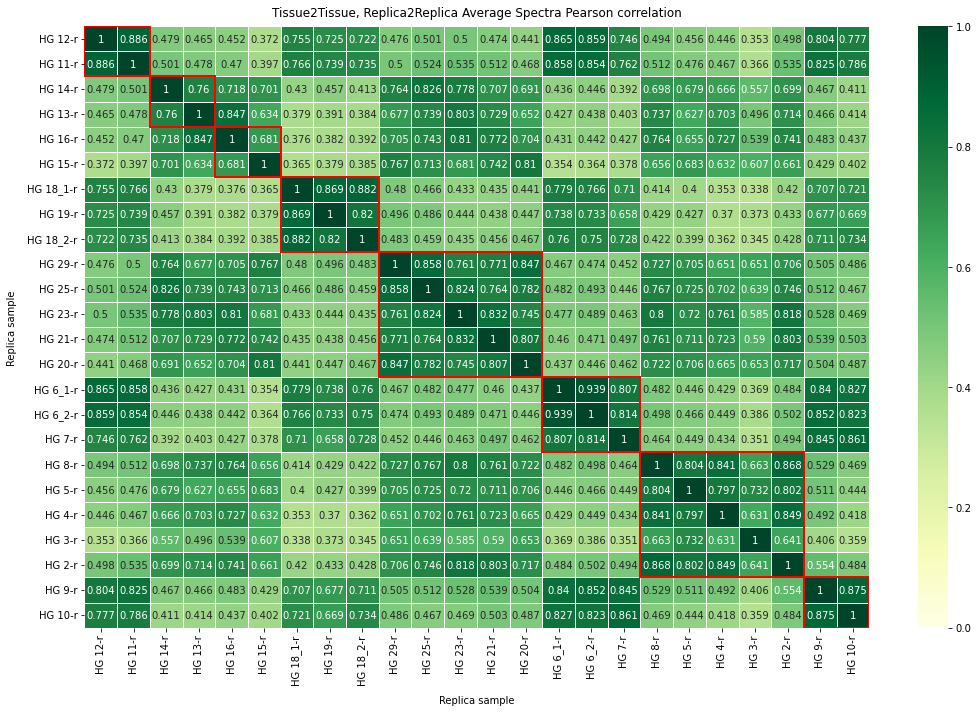

In [11]:
# Create correlation data frame
r_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "replica"].sample_file_name
r_sample_file_name = r_sample_file_name.reset_index(drop=True)

corr_df = corr(r_sample_file_name, r_sample_file_name, tissue_spectras_mean,
                tissue_spectras_mean, corr_type=CORR_TYPE)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("Tissue2Tissue, Replica2Replica Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Replica sample", labelpad=10)
ax.set_xlabel(f"Replica sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "replica"].groupby('file_name'):
  start_i = r_sample_file_name[r_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = r_sample_file_name[r_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***NonTissue2NonTissue correlation Replica2Replica:***

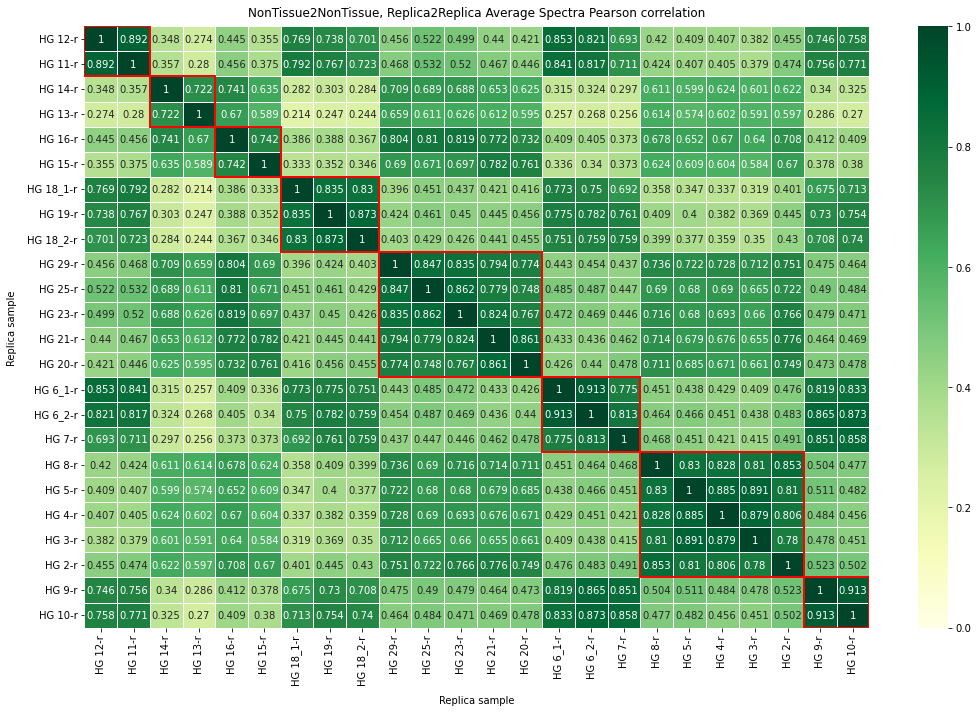

In [15]:
# Create correlation data frame
r_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "replica"].sample_file_name
r_sample_file_name = r_sample_file_name.reset_index(drop=True)

corr_df = corr(r_sample_file_name, r_sample_file_name, non_tissue_spectras_mean,
                non_tissue_spectras_mean, corr_type=CORR_TYPE)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("NonTissue2NonTissue, Replica2Replica Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Replica sample", labelpad=10)
ax.set_xlabel(f"Replica sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "replica"].groupby('file_name'):
  start_i = r_sample_file_name[r_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = r_sample_file_name[r_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***Tissue2NonTissue correlation Replica2Replica:***

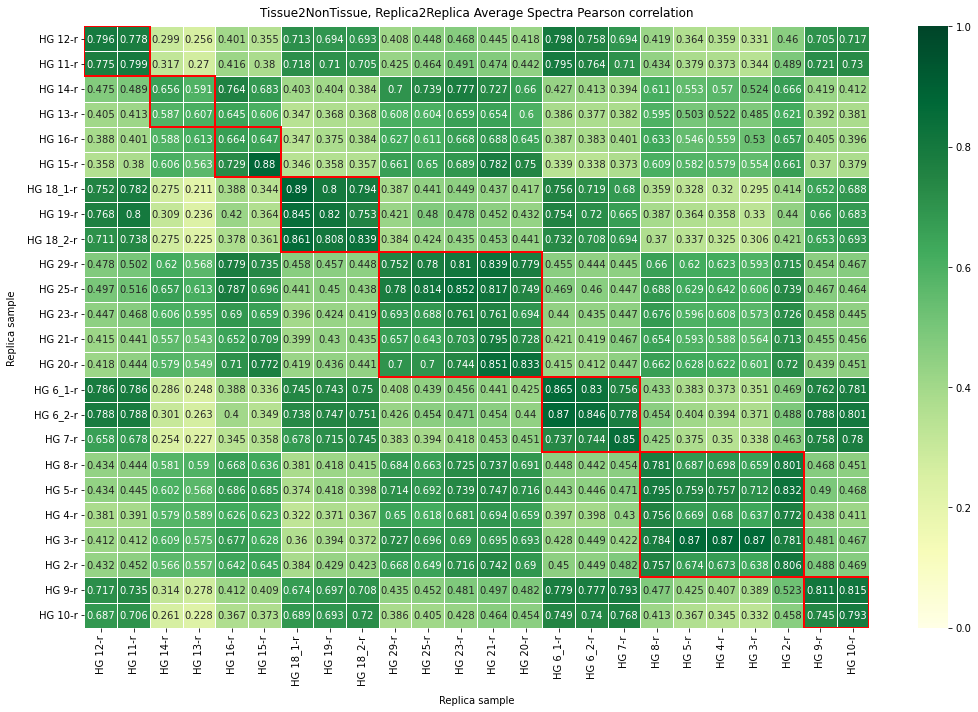

In [16]:
# Create correlation data frame
r_sample_file_name = metadata_df[metadata_df.sample_type ==
                                  "replica"].sample_file_name
r_sample_file_name = r_sample_file_name.reset_index(drop=True)

corr_df = corr(r_sample_file_name, r_sample_file_name, tissue_spectras_mean,
                non_tissue_spectras_mean, corr_type=CORR_TYPE)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                  annot=True,
                  cmap="YlGn",
                  vmin=0,
                  vmax=1,
                  fmt=".3g",
                  linewidth=.5,
                  linecolor='w')
ax.set_title("Tissue2NonTissue, Replica2Replica Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Replica sample", labelpad=10)
ax.set_xlabel(f"Replica sample", labelpad=10)

# Mark cells of sample in same image
for group_name, df_group in metadata_df[metadata_df.sample_type ==
                                        "replica"].groupby('file_name'):
  start_i = r_sample_file_name[r_sample_file_name ==
                                df_group.iloc[0].sample_file_name].index[0]
  end_i = r_sample_file_name[r_sample_file_name ==
                              df_group.iloc[-1].sample_file_name].index[0]
  span = end_i - start_i + 1
  ax.add_patch(
      Rectangle((start_i, start_i),
                span,
                span,
                fill=False,
                edgecolor="red",
                lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***Tissue2Tissue correlation Section2Replica:***

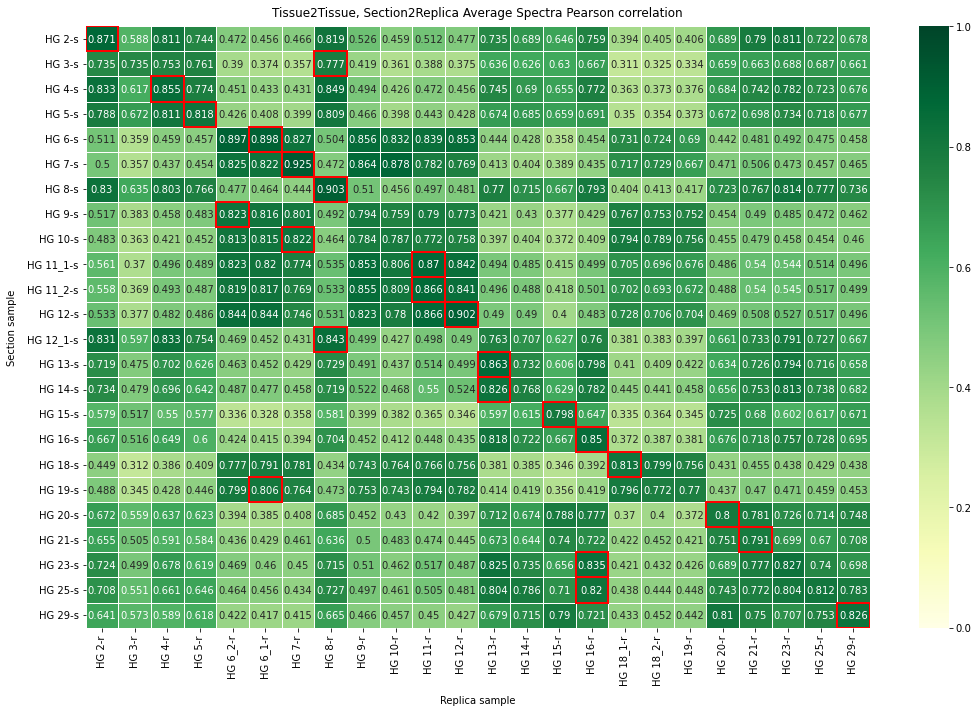

In [17]:
# Create correlation data frame
metadata_df_sort = metadata_df.sort_values("sample_number")
r_sample_file_name = metadata_df_sort[metadata_df_sort.sample_type ==
                                 "replica"].sample_file_name
r_sample_file_name = r_sample_file_name.reset_index(drop=True)
s_sample_file_name = metadata_df_sort[metadata_df_sort.sample_type ==
                                 "section"].sample_file_name
s_sample_file_name = s_sample_file_name.reset_index(drop=True)

corr_df = corr(s_sample_file_name, r_sample_file_name, tissue_spectras_mean,
               tissue_spectras_mean, corr_type=CORR_TYPE)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                 annot=True,
                 cmap="YlGn",
                 vmin=0,
                 vmax=1,
                 fmt=".3g",
                 linewidth=.5,
                 linecolor='w')
ax.set_title("Tissue2Tissue, Section2Replica Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Section sample", labelpad=10)
ax.set_xlabel(f"Replica sample", labelpad=10)

# Mark cells of max correlation between section and replica
row_max = corr_df.idxmax(axis=1)
for row, index in enumerate(s_sample_file_name):
  position = corr_df.columns.get_loc(row_max[index])
  ax.add_patch(
      Rectangle((position, row), 1, 1, fill=False, edgecolor='red', lw=2))

# Show plot
plt.tight_layout()
plt.show()

### ***NonTissue2NonTissue correlation Section2Replica:***

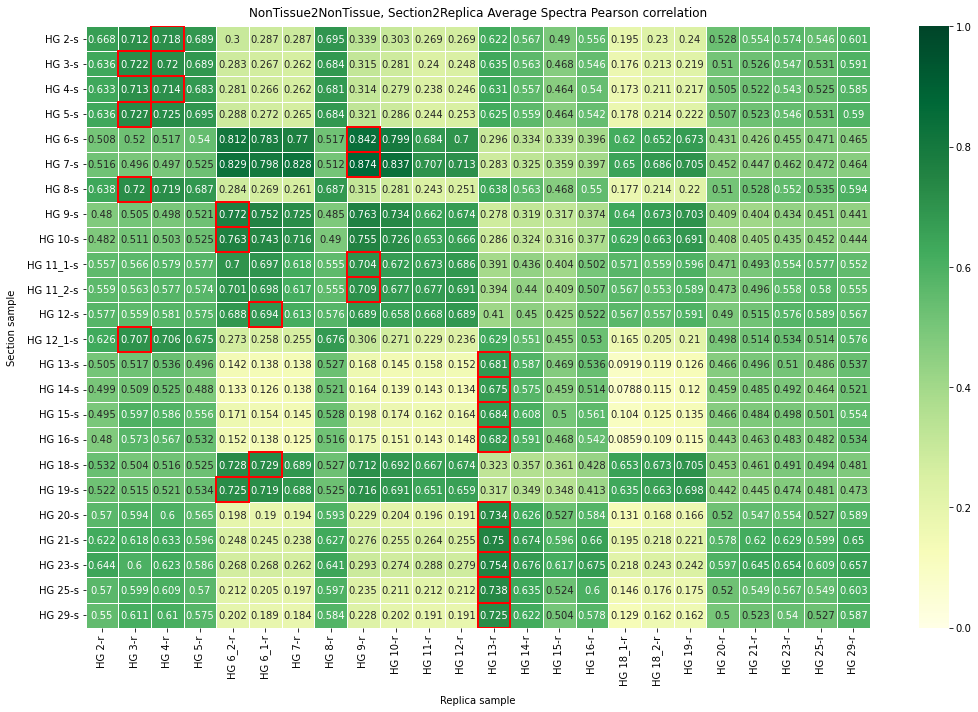

In [18]:
# Create correlation data frame
metadata_df_sort = metadata_df.sort_values("sample_number")
r_sample_file_name = metadata_df_sort[metadata_df_sort.sample_type ==
                                 "replica"].sample_file_name
r_sample_file_name = r_sample_file_name.reset_index(drop=True)
s_sample_file_name = metadata_df_sort[metadata_df_sort.sample_type ==
                                 "section"].sample_file_name
s_sample_file_name = s_sample_file_name.reset_index(drop=True)

corr_df = corr(s_sample_file_name, r_sample_file_name, non_tissue_spectras_mean,
               non_tissue_spectras_mean, corr_type=CORR_TYPE)

# Plot correlation data frame
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr_df,
                 annot=True,
                 cmap="YlGn",
                 vmin=0,
                 vmax=1,
                 fmt=".3g",
                 linewidth=.5,
                 linecolor='w')
ax.set_title("NonTissue2NonTissue, Section2Replica Average Spectra Pearson correlation", pad=10)
ax.set_ylabel(f"Section sample", labelpad=10)
ax.set_xlabel(f"Replica sample", labelpad=10)

# Mark cells of max correlation between section and replica
row_max = corr_df.idxmax(axis=1)
for row, index in enumerate(s_sample_file_name):
  position = corr_df.columns.get_loc(row_max[index])
  ax.add_patch(
      Rectangle((position, row), 1, 1, fill=False, edgecolor='red', lw=2))

# Show plot
plt.tight_layout()
plt.show()

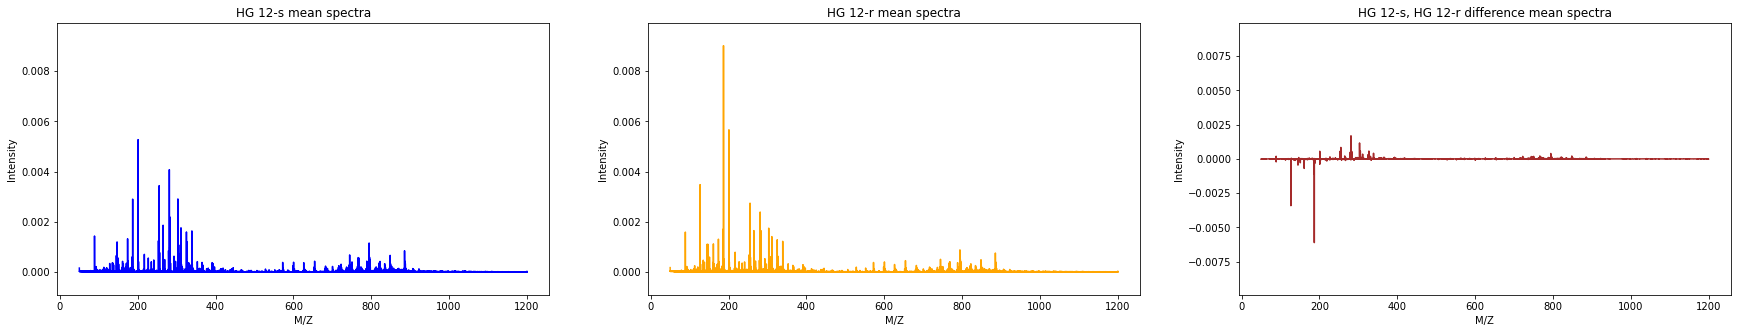

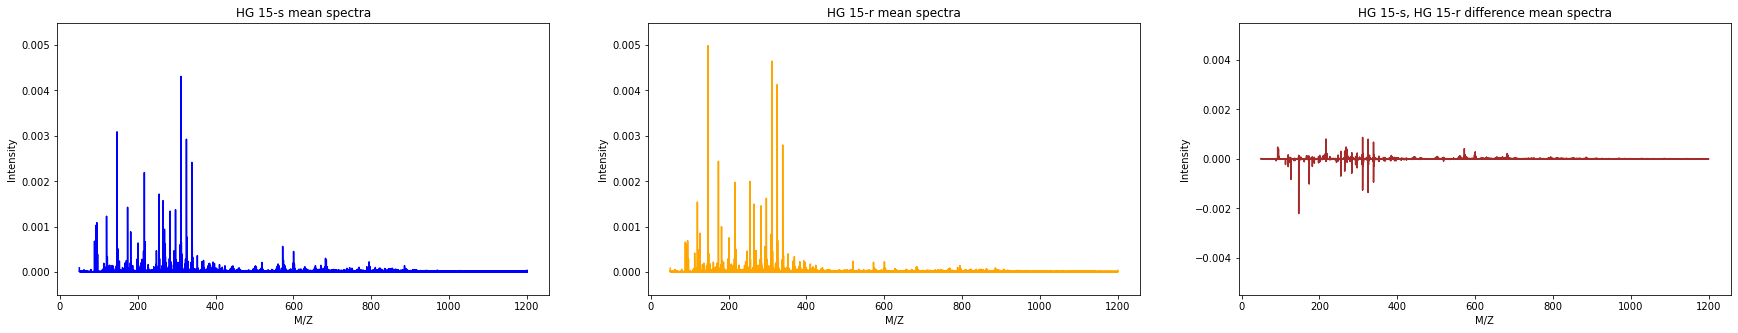

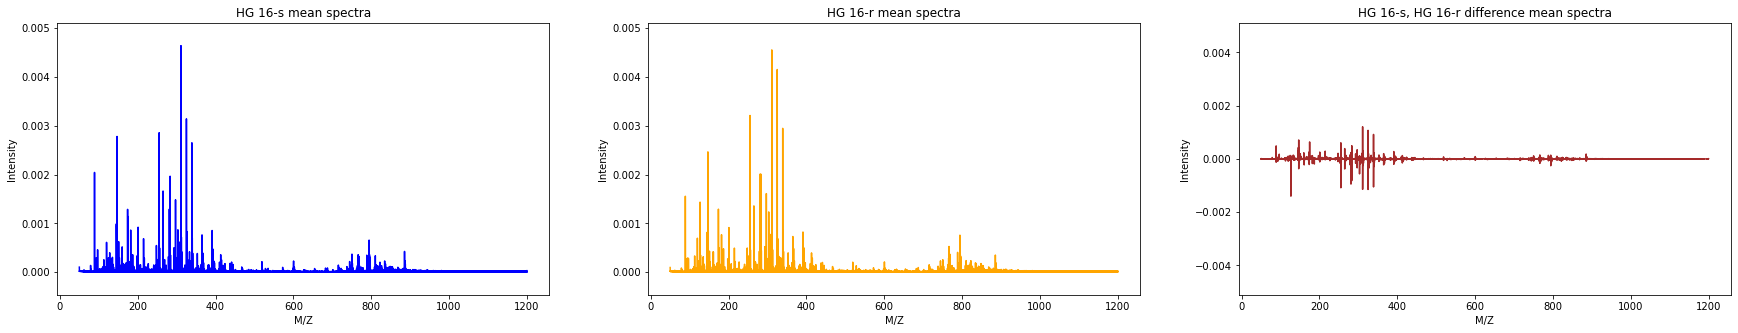

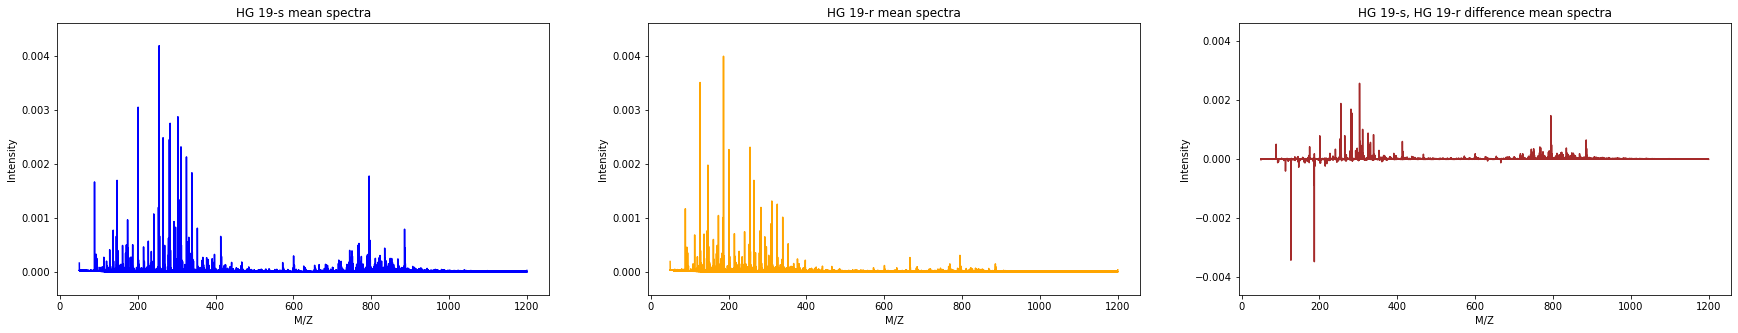

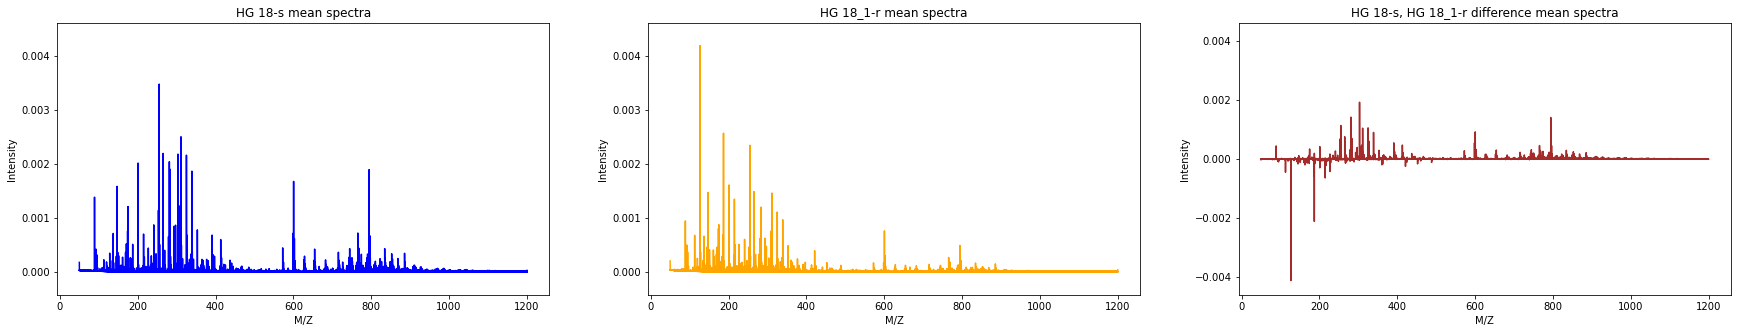

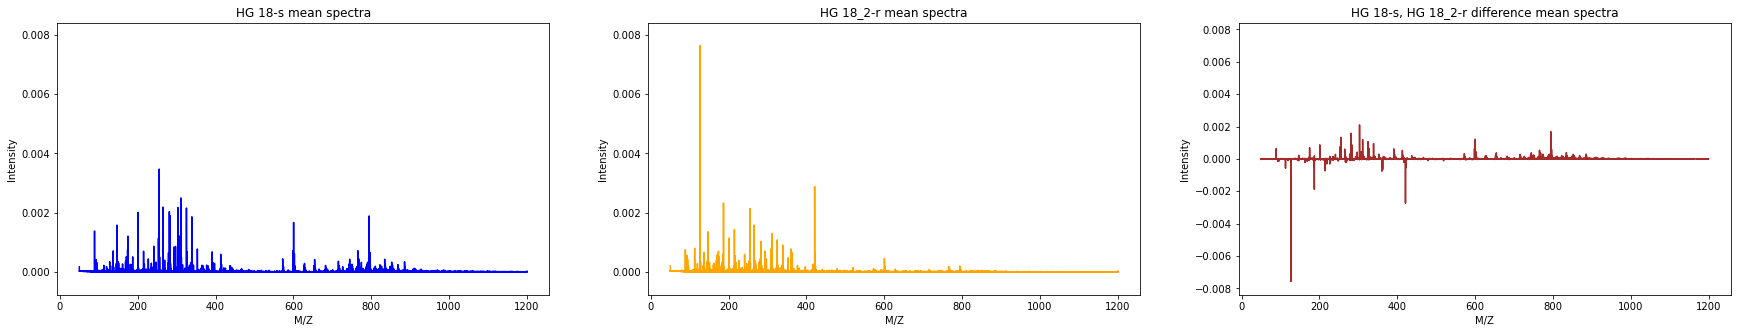

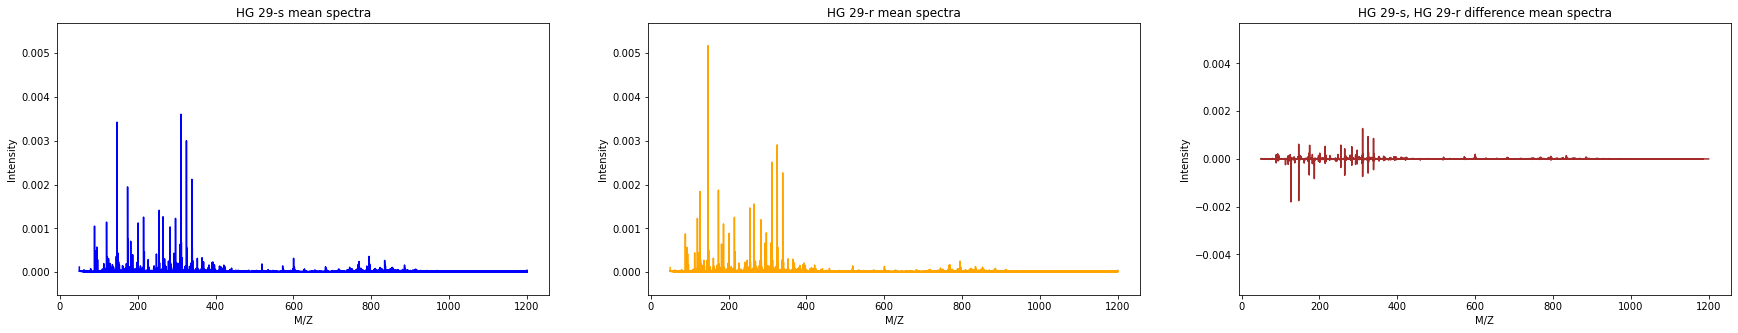

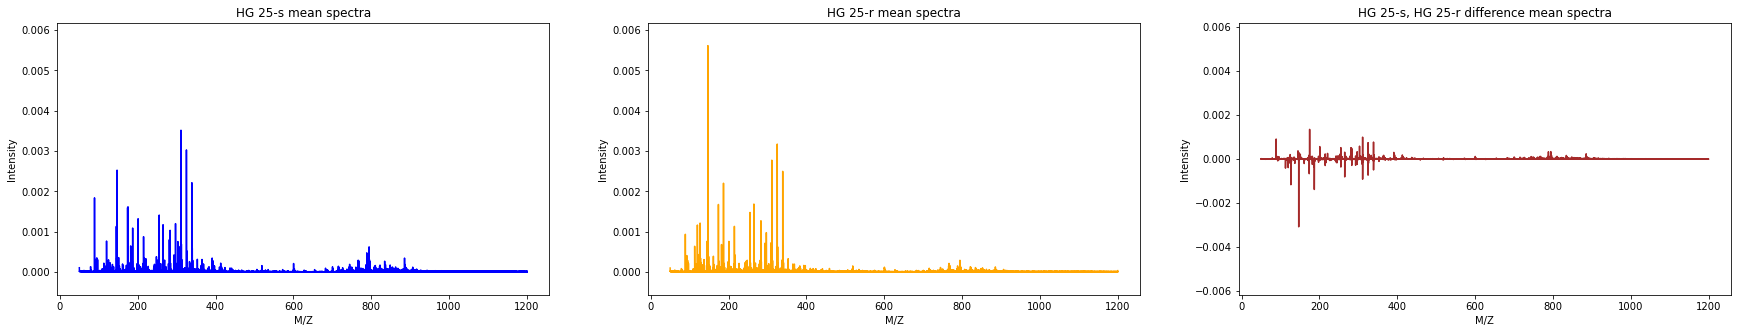

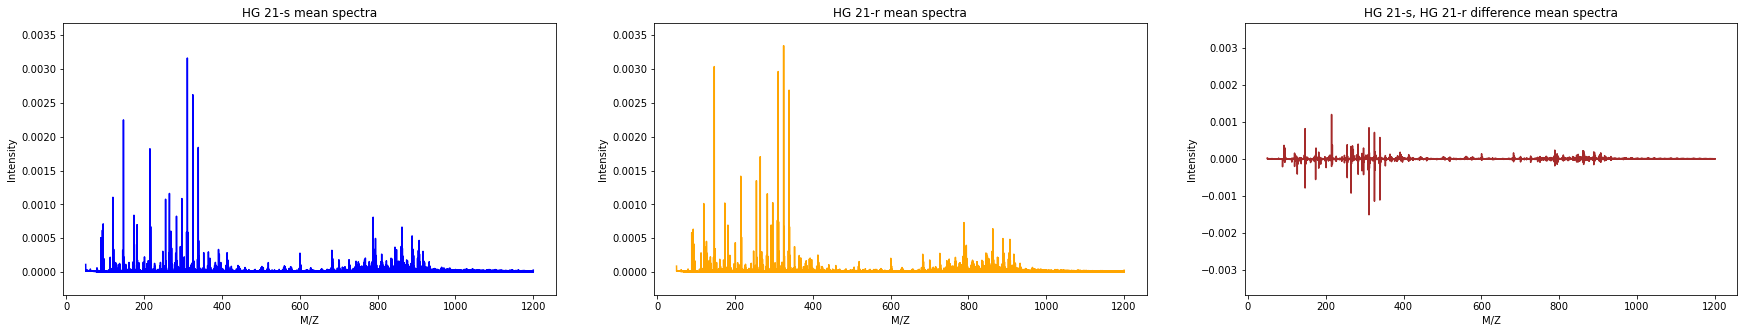

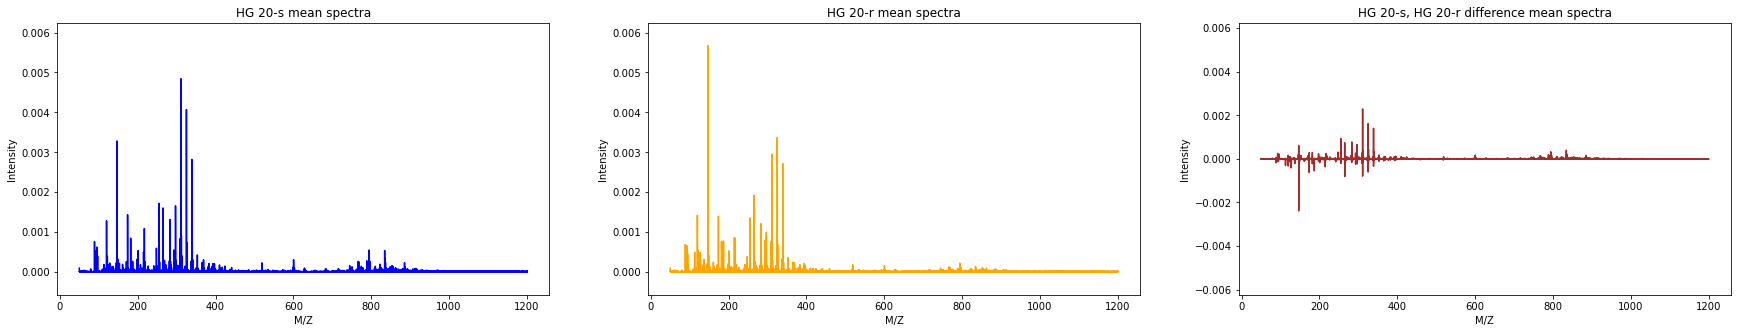

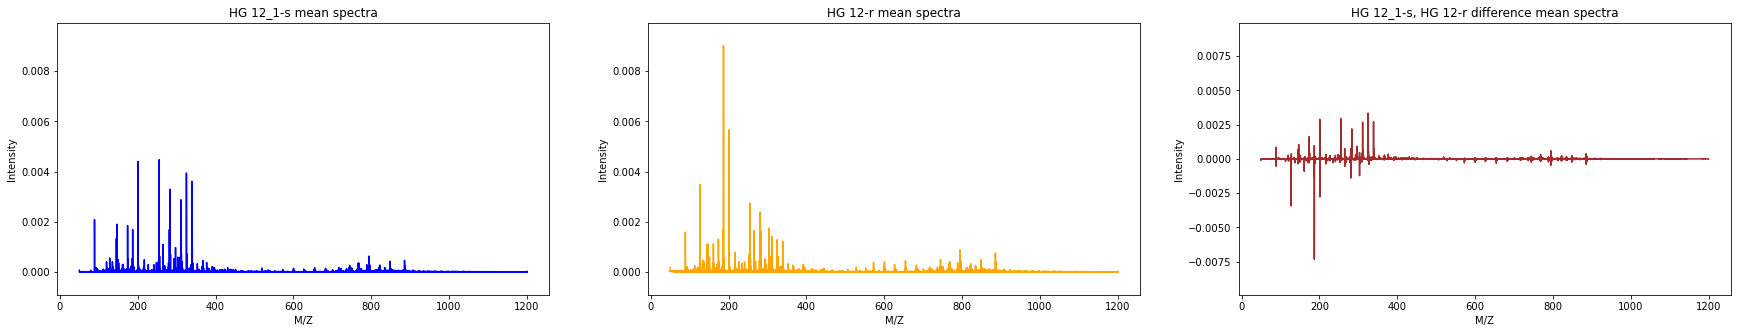

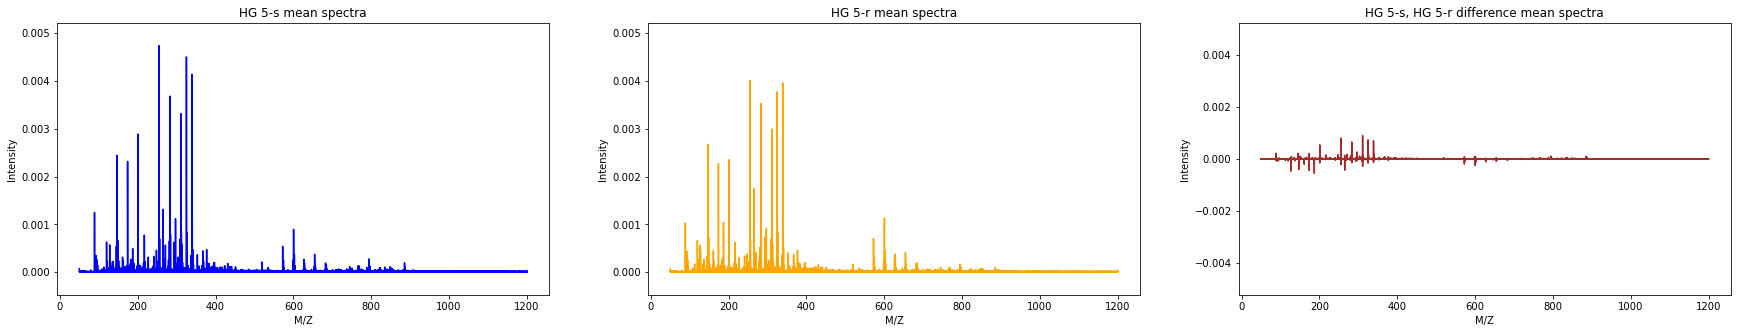

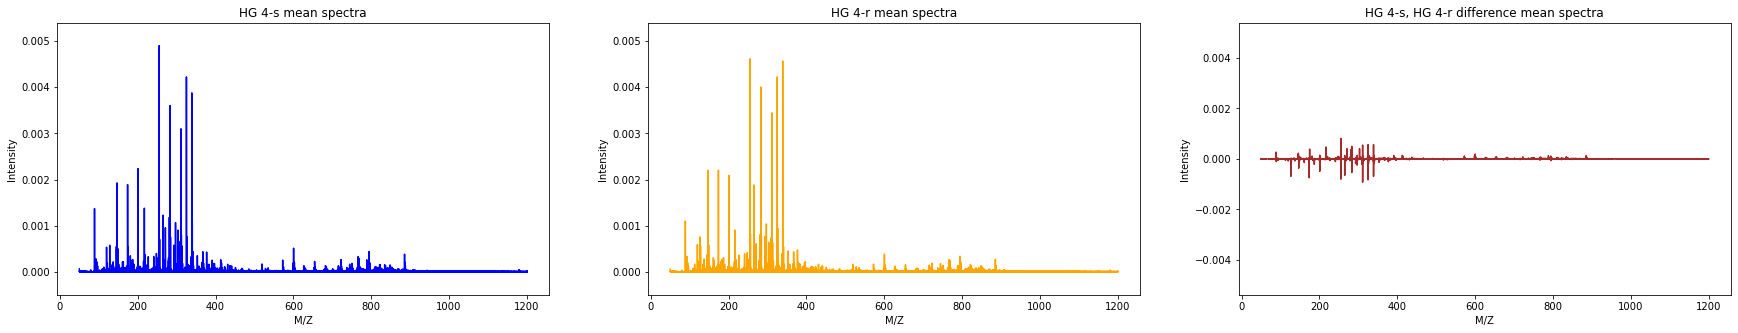

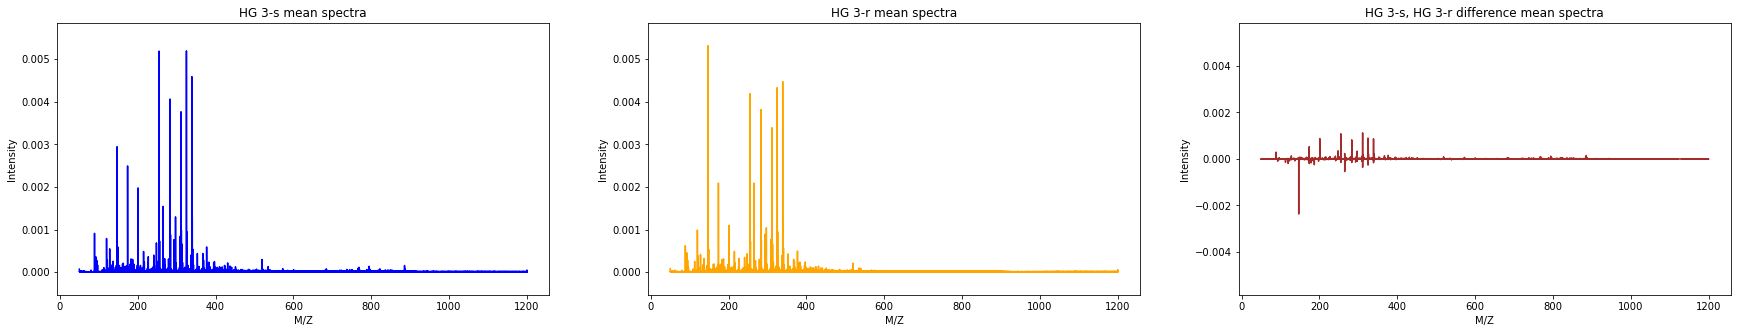

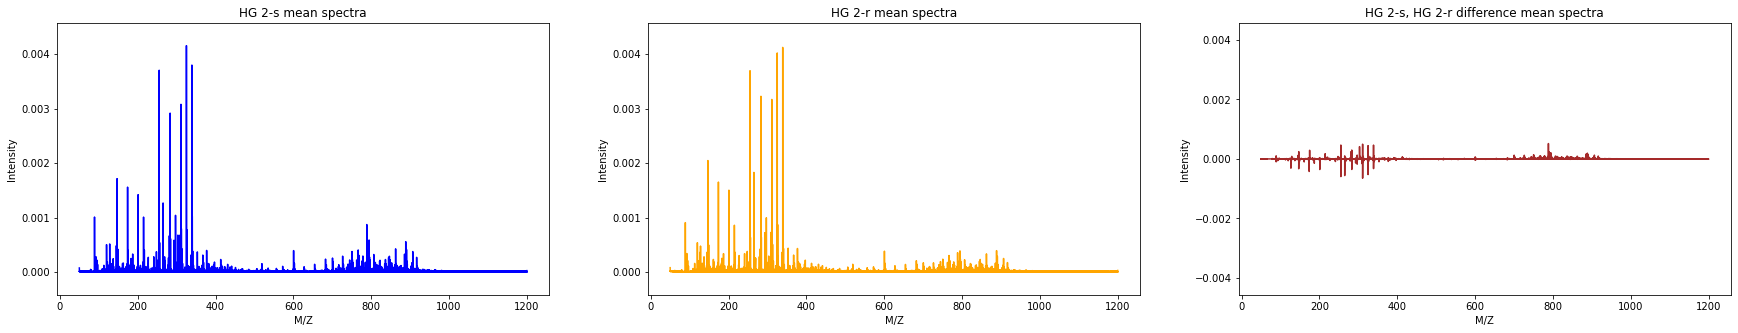

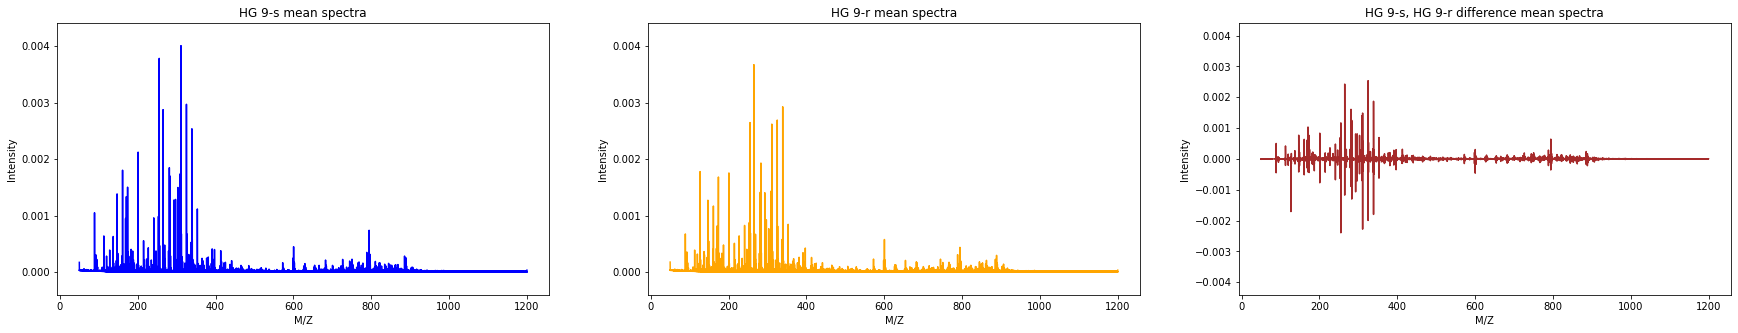

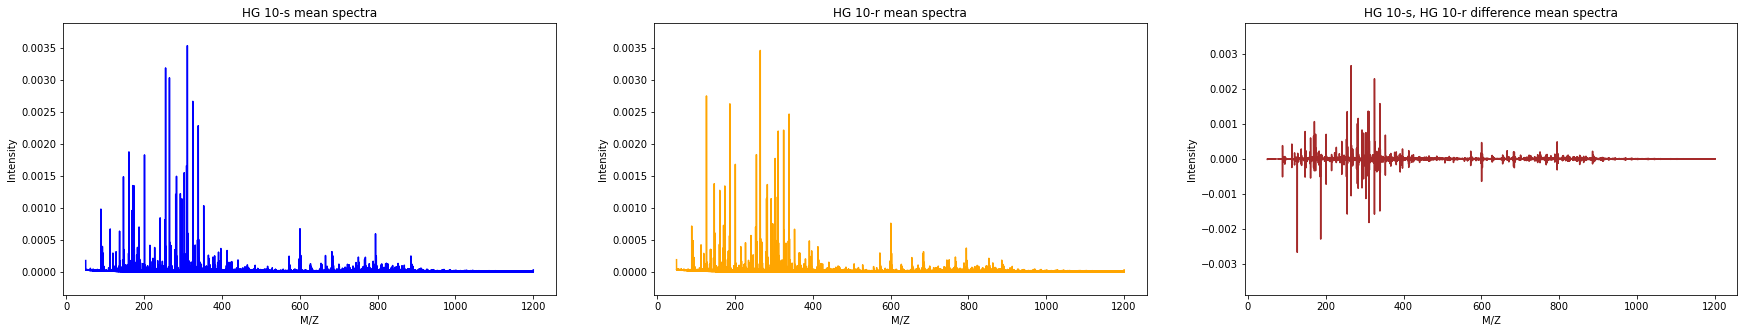

In [19]:
# Loop over each MSI
for msi_1, msi_1_mean in tissue_spectras_mean.items():
  # Check if MSI is section type and not replica
  # in order to not plot twice
  if "s" in msi_1:
    # Get MSI sample number
    msi_1_num = msi_1.replace("HG ","").replace("-s", "").replace("_1", "").replace("_2", "")
    # Loop over each MSI
    for msi_2, msi_2_mean in tissue_spectras_mean.items():
      # Get MSI sample number
      msi_2_num = msi_2.replace("HG ","").replace("-r", "").replace("_1", "").replace("_2", "")
      # Check if both MSI are the same sample (a replica, section pair)
      if msi_1_num == msi_2_num and msi_1 != msi_2 and 's' not in msi_2:
        # Create subplot
        fig, axes = plt.subplots(1, 3, figsize=(30, 5))
        # Get maximum intensity in order to make plot y range the same
        max_y = np.maximum(np.max(msi_1_mean), np.max(msi_2_mean))
        # Create margin for y axis in plot
        margin = 0.1 * max_y
        # Plot section msi mean spectrum
        axes[0].plot(mzs, msi_1_mean, color="Blue")
        axes[0].set_title(f"{msi_1} mean spectra")
        axes[0].set_xlabel("M/Z")
        axes[0].set_ylabel("Intensity")
        axes[0].set_ylim([-margin, max_y + margin])
        # Plot replica msi mean spectrum
        axes[1].plot(mzs, msi_2_mean, color="Orange")
        axes[1].set_title(f"{msi_2} mean spectra")
        axes[1].set_xlabel("M/Z")
        axes[1].set_ylabel("Intensity")
        axes[1].set_ylim([-margin, max_y + margin])
        # Plot section & replica msi mean spectrum difference
        axes[2].plot(mzs, msi_1_mean - msi_2_mean, color="Brown")
        axes[2].set_title(f"{msi_1}, {msi_2} difference mean spectra")
        axes[2].set_xlabel("M/Z")
        axes[2].set_ylabel("Intensity")
        axes[2].set_ylim([- (max_y + margin), max_y + margin])
        # Display plot
        plt.show()

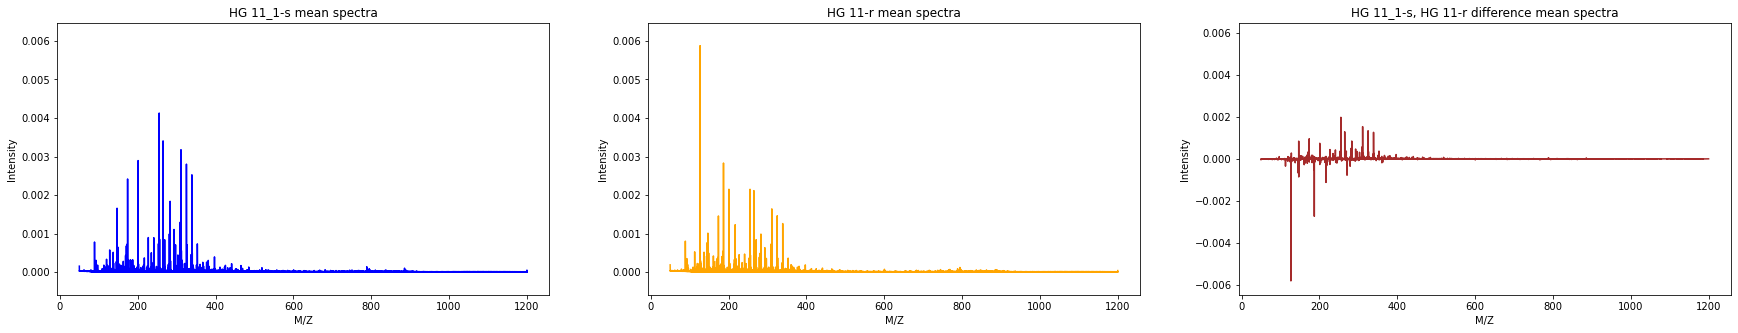

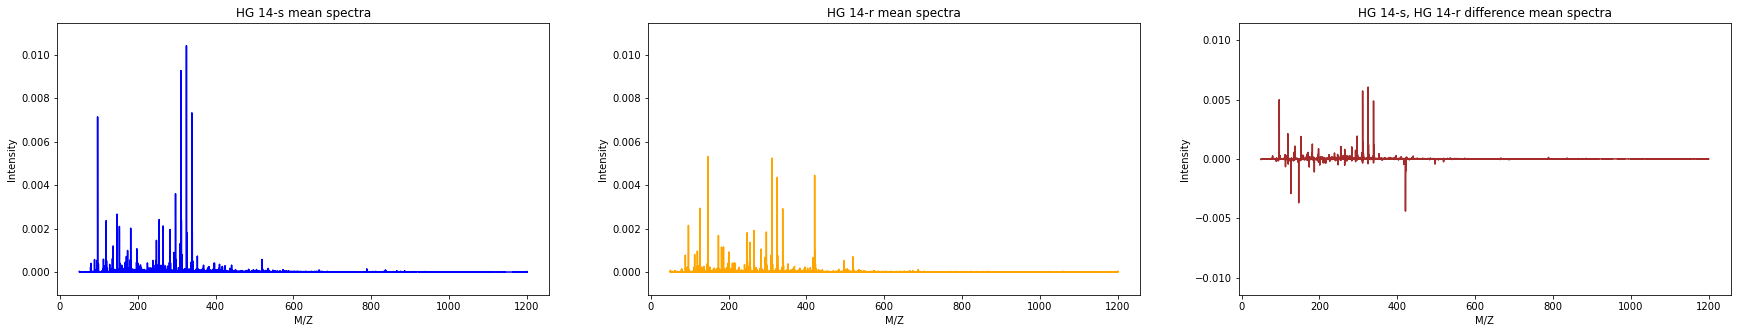

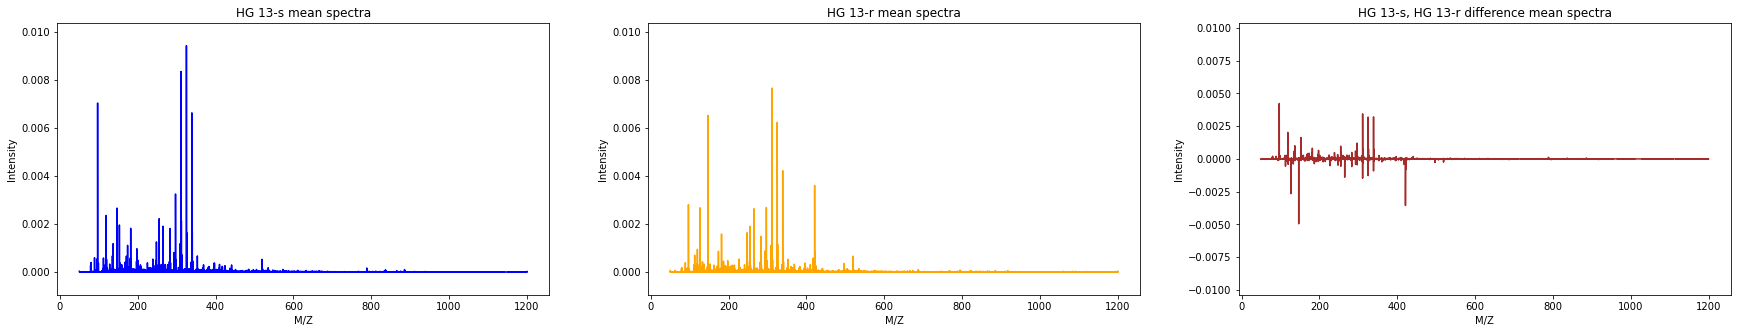

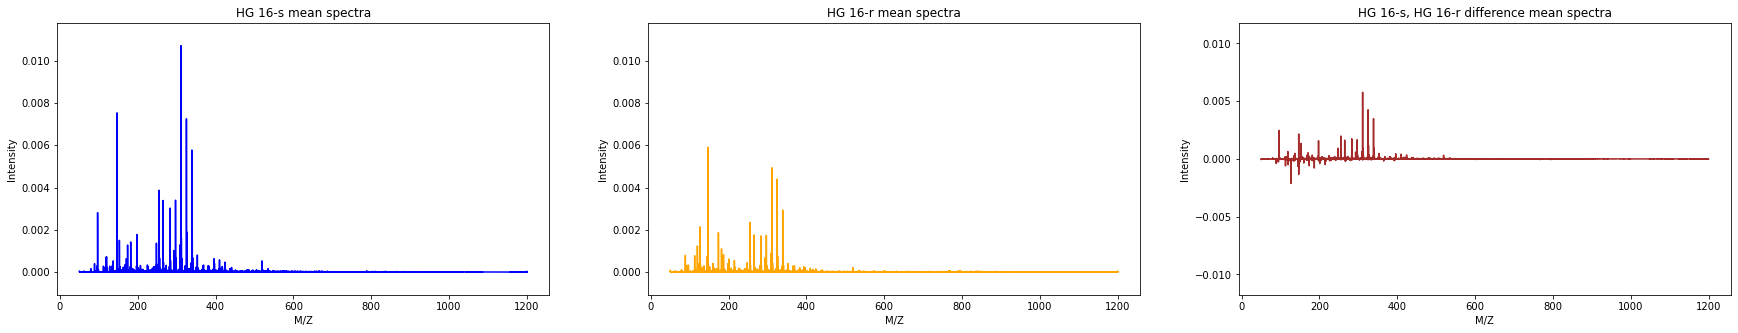

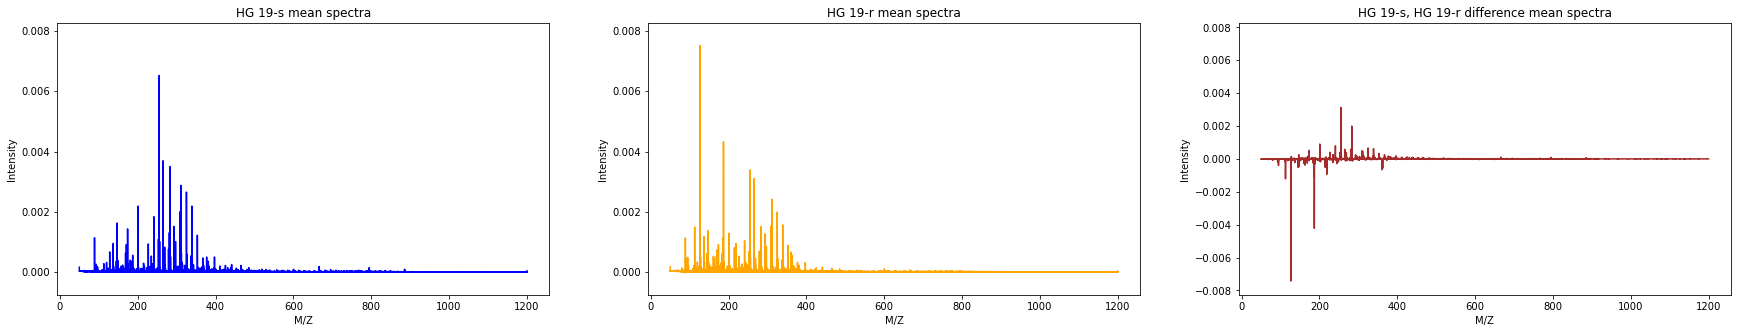

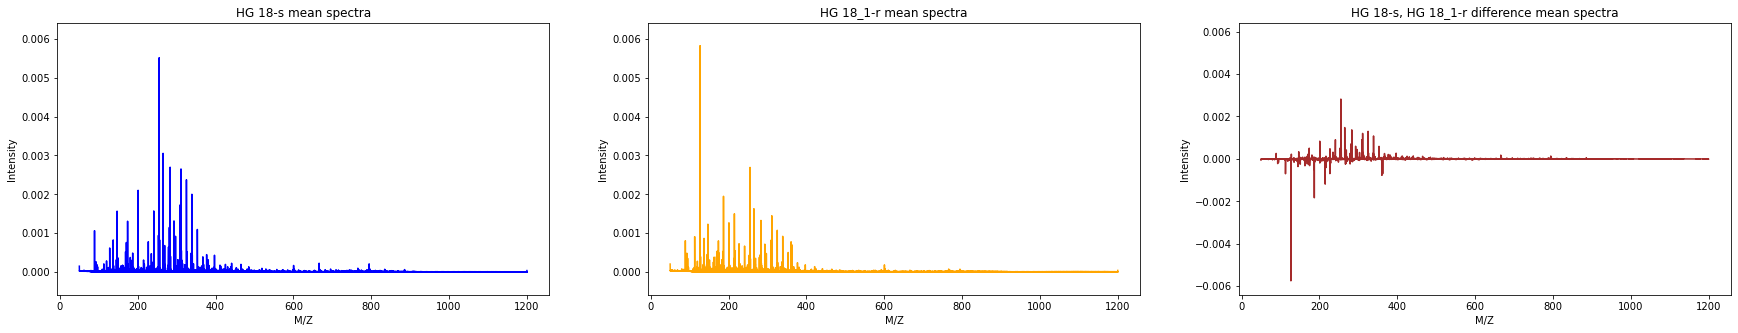

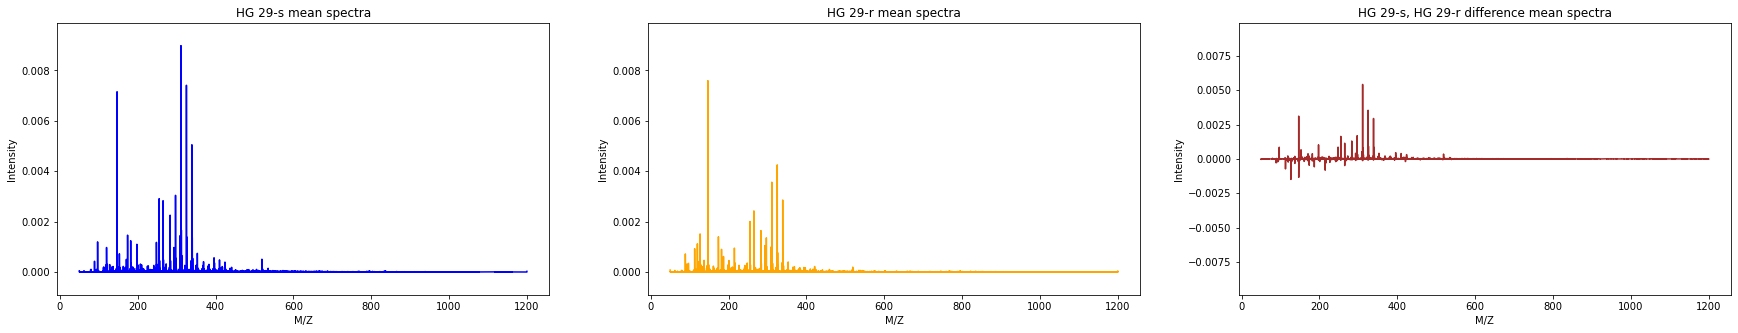

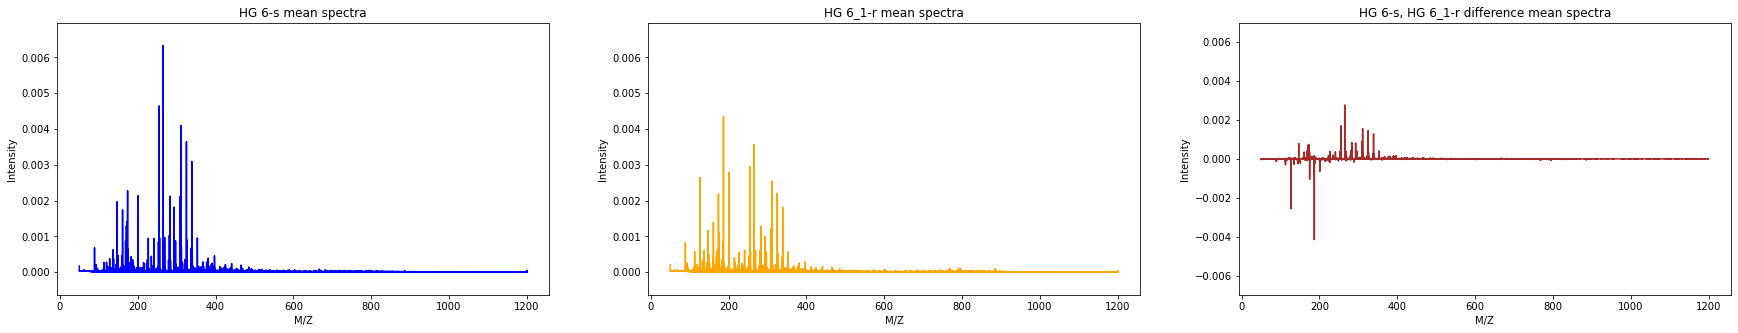

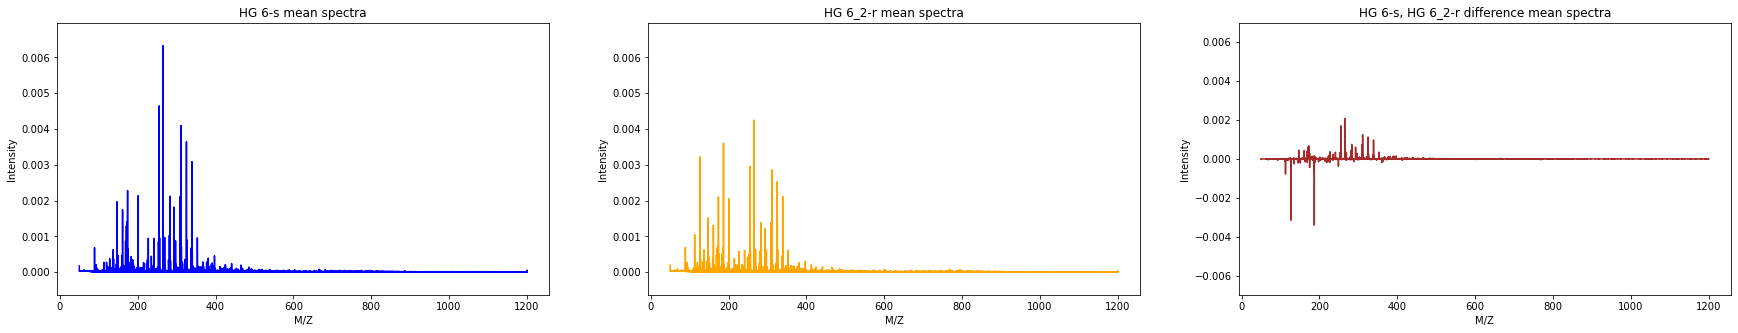

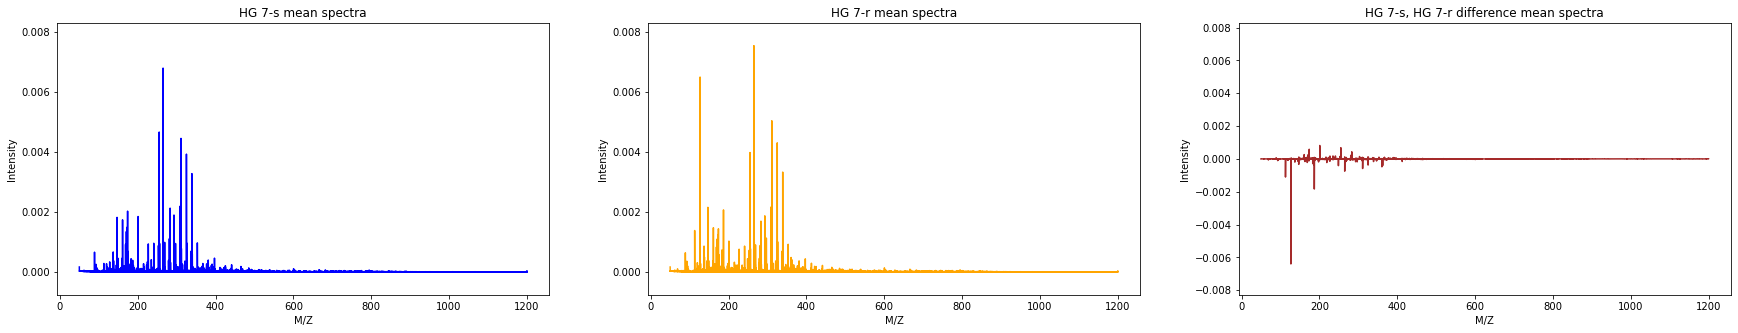

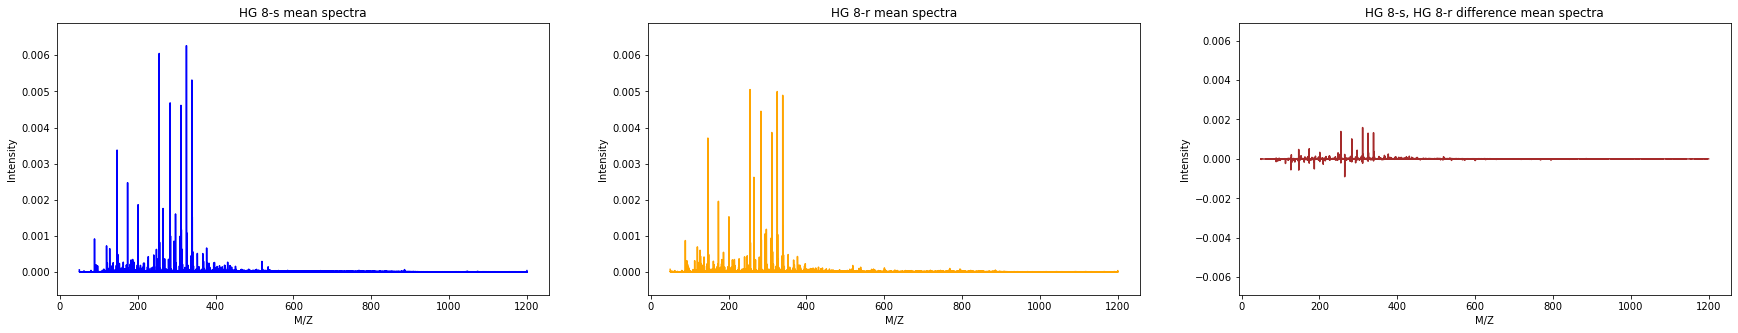

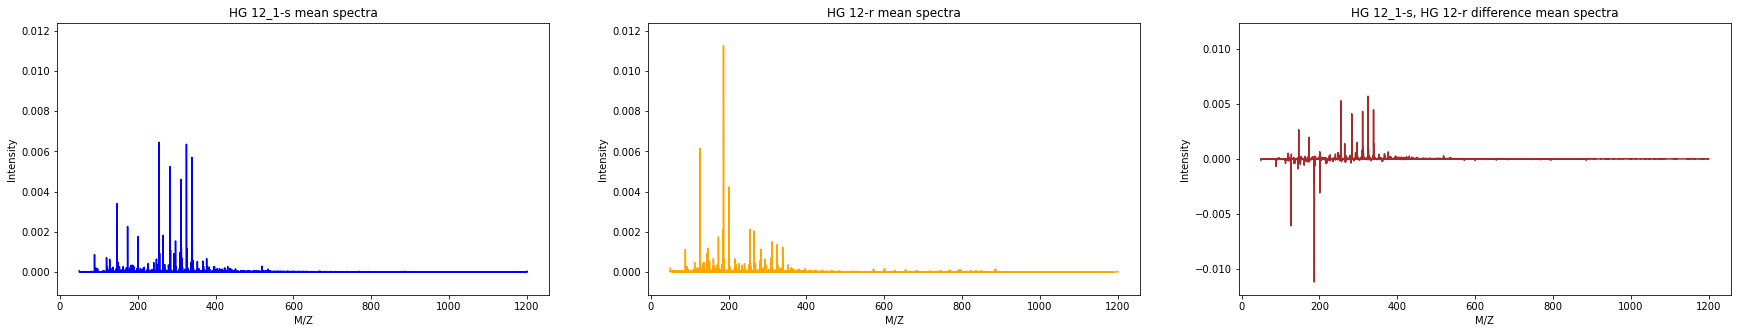

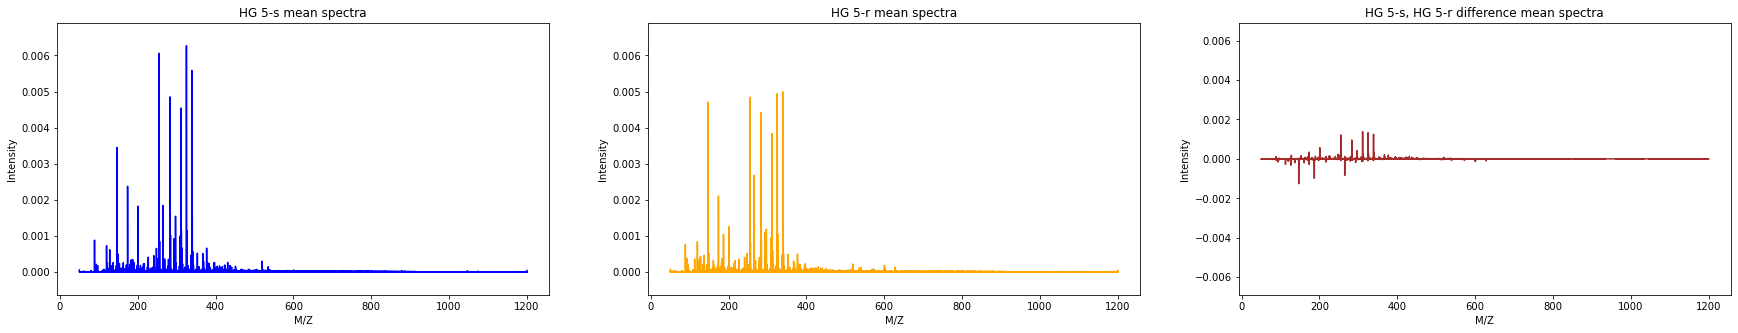

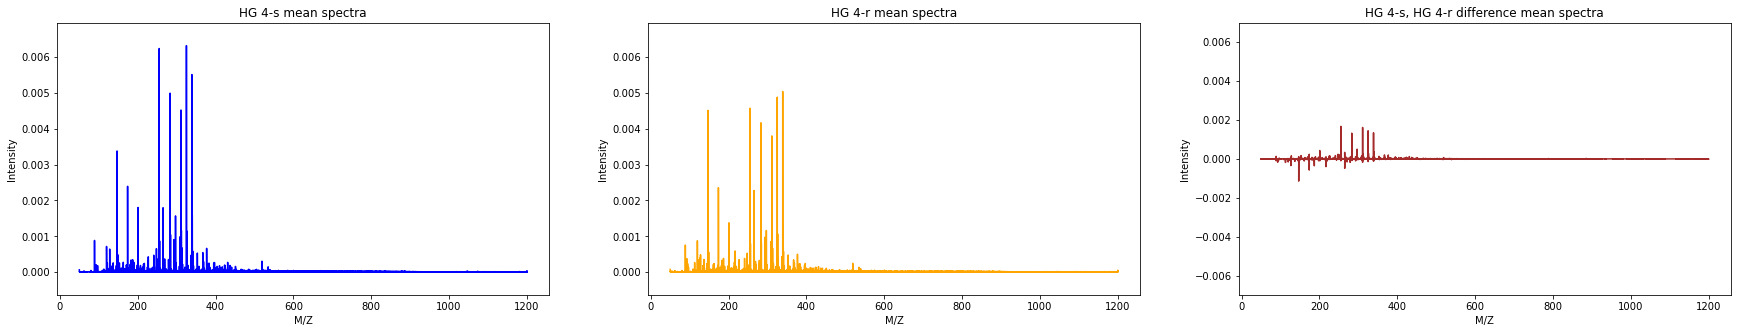

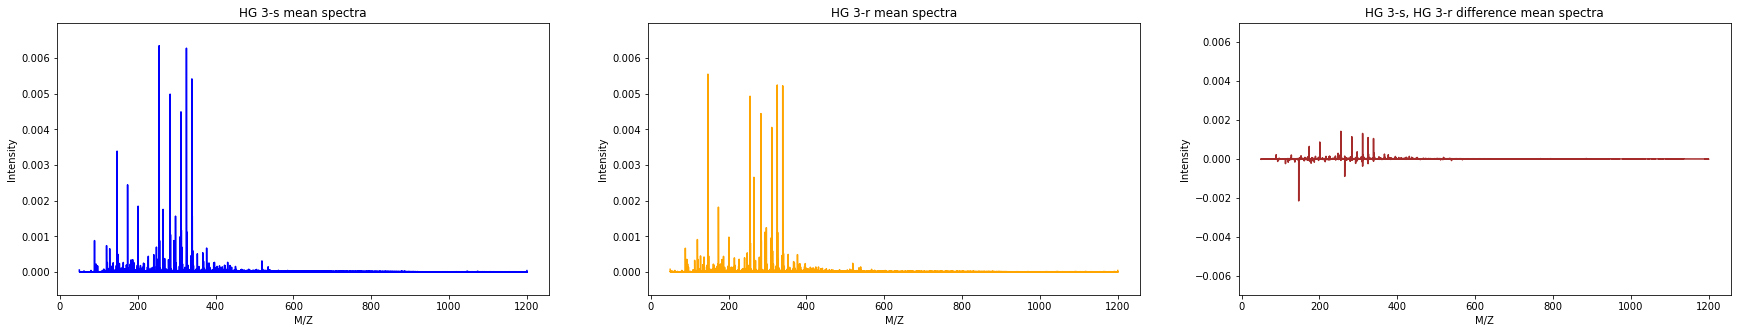

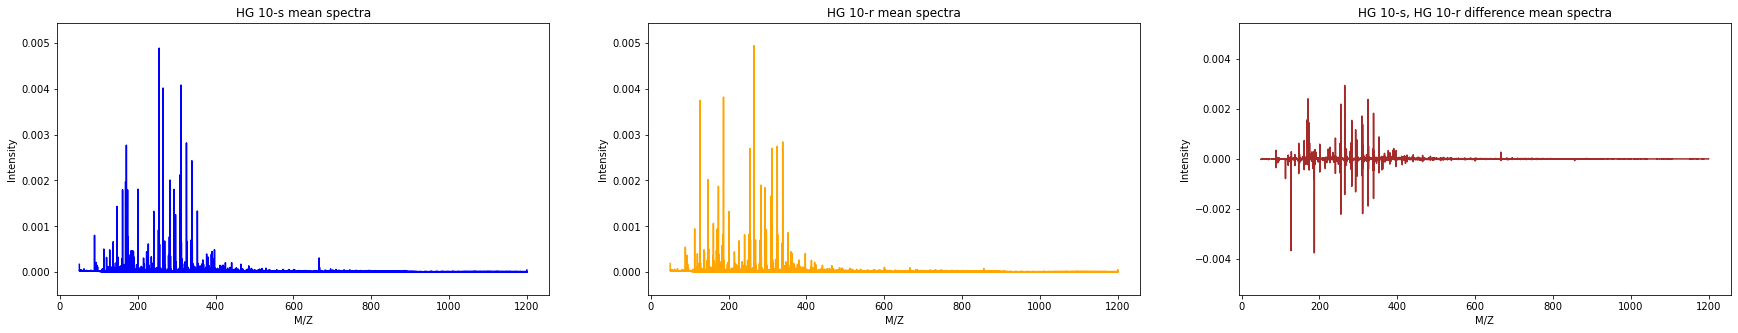

In [20]:
# Loop over each MSI
for msi_1, msi_1_mean in non_tissue_spectras_mean.items():
  # Check if MSI is section type and not replica
  # in order to not plot twice
  if "s" in msi_1:
    # Get MSI sample number
    msi_1_num = msi_1.replace("HG ","").replace("-s", "").replace("_1", "").replace("_2", "")
    # Loop over each MSI
    for msi_2, msi_2_mean in non_tissue_spectras_mean.items():
      # Get MSI sample number
      msi_2_num = msi_2.replace("HG ","").replace("-r", "").replace("_1", "").replace("_2", "")
      # Check if both MSI are the same sample (a replica, section pair)
      if msi_1_num == msi_2_num and msi_1 != msi_2 and 's' not in msi_2:
        # Create subplot
        fig, axes = plt.subplots(1, 3, figsize=(30, 5))
        # Get maximum intensity in order to make plot y range the same
        max_y = np.maximum(np.max(msi_1_mean), np.max(msi_2_mean))
        # Create margin for y axis in plot
        margin = 0.1 * max_y
        # Plot section msi mean spectrum
        axes[0].plot(mzs, msi_1_mean, color="Blue")
        axes[0].set_title(f"{msi_1} mean spectra")
        axes[0].set_xlabel("M/Z")
        axes[0].set_ylabel("Intensity")
        axes[0].set_ylim([-margin, max_y + margin])
        # Plot replica msi mean spectrum
        axes[1].plot(mzs, msi_2_mean, color="Orange")
        axes[1].set_title(f"{msi_2} mean spectra")
        axes[1].set_xlabel("M/Z")
        axes[1].set_ylabel("Intensity")
        axes[1].set_ylim([-margin, max_y + margin])
        # Plot section & replica msi mean spectrum difference
        axes[2].plot(mzs, msi_1_mean - msi_2_mean, color="Brown")
        axes[2].set_title(f"{msi_1}, {msi_2} difference mean spectra")
        axes[2].set_xlabel("M/Z")
        axes[2].set_ylabel("Intensity")
        axes[2].set_ylim([- (max_y + margin), max_y + margin])
        # Display plot
        plt.show()

# ***With sample z-score normalization:***

In [21]:
# Create dict's to store each sample spectra's sum and count
# for tissue and non tissue spectra's
tissue_spectras_mean = {}
non_tissue_spectras_mean = {}

# Define object to store common mz values
mzs = None

# Loop over each sample
for _, row in tqdm(metadata_df.iterrows(),
                   total=metadata_df.shape[0],
                   desc="MSI Loop"):
  #
  with ImzMLParser(os.path.join(DHG_IN_PATH,
                                f"{row.sample_file_name}.imzML")) as reader:
    #
    mzs, data = read_msi(reader)
    #
    local_tic_img = data[:, :, ((mzs > 600) & (mzs < 900))].sum(axis=-1)
    # Threshold image to separate tissue spectra from background
    thresh_img = local_tic_img > filters.threshold_mean(local_tic_img)
    #
    non_tissue_mean = data[~thresh_img, :].mean(axis=0)
    non_tissue_std = data[~thresh_img, :].std(axis=0)
    #
    tissue_spectras_mean[row.sample_file_name] = (
        (data[thresh_img, :] - non_tissue_mean) / non_tissue_std).mean(axis=0)
    #
    non_tissue_spectras_mean[row.sample_file_name] = (
        (data[~thresh_img, :] - non_tissue_mean) / non_tissue_std).mean(axis=0)


MSI Loop:   0%|          | 0/48 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2254 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2596 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2772 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2412 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1856 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4368 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4875 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3871 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2508 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3465 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3074 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2928 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3604 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4422 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3111 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4488 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1620 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1584 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3477 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4256 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3835 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4500 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3658 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4400 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2583 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2852 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2916 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3484 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1496 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1452 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2184 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1395 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1470 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4896 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2898 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1710 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1850 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2184 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1377 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4420 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3111 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2562 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5135 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/5934 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/3192 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/4026 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/1886 [00:00<?, ?it/s]

Spectra Loop:   0%|          | 0/2304 [00:00<?, ?it/s]

# ***With image z-score normalization:***

In [ ]:
# Create dict's to store each sample spectra's sum and count
# for tissue and non tissue spectra's
tissue_spectras_mean = {}
non_tissue_spectras_mean = {}

# Define object to store common mz values
mzs = None

# Loop over each sample
for file_name, group_df in tqdm(metadata_df.groupby("file_name")):
  samples_non_tissue = []
  for _, row in group_df.iterrows():
    #
    with ImzMLParser(os.path.join(DHG_IN_PATH,
                                  f"{row.sample_file_name}.imzML")) as reader:
      #
      mzs, data = read_msi(reader)
      #
      local_tic_img = data[:, :, ((mzs > 600) & (mzs < 900))].sum(axis=-1)
      # Threshold image to separate tissue spectra from background
      thresh_img = local_tic_img > filters.threshold_mean(local_tic_img)
      #
      samples_non_tissue.append(data[~thresh_img, :])

  non_tissue_mean = np.concatenate(samples_non_tissue).mean(axis=0)
  non_tissue_std = np.concatenate(samples_non_tissue).std(axis=0)

  for _, row in group_df.iterrows():
    #
    with ImzMLParser(os.path.join(DHG_IN_PATH,
                                  f"{row.sample_file_name}.imzML")) as reader:
      #
      mzs, data = read_msi(reader)
      #
      local_tic_img = data[:, :, ((mzs > 600) & (mzs < 900))].sum(axis=-1)
      # Threshold image to separate tissue spectra from background
      thresh_img = local_tic_img > filters.threshold_mean(local_tic_img)

      #
      tissue_spectras_mean[row.sample_file_name] = (
          (data[thresh_img, :] - non_tissue_mean) / non_tissue_std).mean(axis=0)
      #
      non_tissue_spectras_mean[row.sample_file_name] = (
          (data[~thresh_img, :] - non_tissue_mean) /
          non_tissue_std).mean(axis=0)
